<a href="https://colab.research.google.com/github/Rameshkumar789/Computational-Menthods-INFO-5731/blob/main/Project_Pre_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from google.colab import files

In [ ]:
uploaded = files.upload()

Saving project_50.csv to project_50.csv


In [ ]:
df=pd.read_csv('/content/project_50.csv')

In [ ]:
df

,Unnamed: 0,SourceID,Title,TextWhereRefMention
0,0,176908,Urban wages and labor market agglomeration,"Wheaton and Lewis, Ref{target=#b33, content=},..."
1,1,176908,NaN,"Glaeser and MarÃ©, Ref{target=#b9, content=}, ..."
2,2,176908,NaN,"[Wheeler, Ref{target=#b34, content=}, provides..."
3,3,176908,The Wage Effects of Residential Location and C...,"First, empirical evidence suggests that women ..."
4,4,176908,Race and Gender in the Labor Market,"Second, women typically work fewer hours and y..."
...,...,...,...,...
102024,102024,30685534,Early Learning Standards: Results from a Natio...,Most US states have now developed statements o...
102025,102025,30685534,Inside the Content of InfantToddler Early Lear...,Most US states have now developed statements o...
102026,102026,30685534,Early Learning Guidelines for Infants and Todd...,[Peak bodies in the US have published recommen...
102027,102027,30685534,Early Learning Guidelines for Infants and Todd...,the process used to develop SÃ­olta: The Natio...


## Data Cleaning

In [ ]:
import re

In [ ]:
cleaned_text=[]

for i in range(len(df)):
  temp = re.sub('Ref{.*?}', '', df['TextWhereRefMention'][i])
  temp = re.sub(r'[^\w\s]', '', temp)
  temp= re.sub(' +', ' ', temp).rstrip()
  cleaned_text.append(temp)

In [ ]:
df['cleaned_text']=cleaned_text

In [ ]:
df

,Unnamed: 0,SourceID,Title,TextWhereRefMention,cleaned_text
0,0,176908,Urban wages and labor market agglomeration,"Wheaton and Lewis, Ref{target=#b33, content=},...",Wheaton and Lewis find evidence of increasing ...
1,1,176908,NaN,"Glaeser and MarÃ©, Ref{target=#b9, content=}, ...",Glaeser and MarÃ find a robust urban wage prem...
2,2,176908,NaN,"[Wheeler, Ref{target=#b34, content=}, provides...",Wheeler provides empirical support for a model...
3,3,176908,The Wage Effects of Residential Location and C...,"First, empirical evidence suggests that women ...",First empirical evidence suggests that women a...
4,4,176908,Race and Gender in the Labor Market,"Second, women typically work fewer hours and y...",Second women typically work fewer hours and ye...
...,...,...,...,...,...
102024,102024,30685534,Early Learning Standards: Results from a Natio...,Most US states have now developed statements o...,Most US states have now developed statements o...
102025,102025,30685534,Inside the Content of InfantToddler Early Lear...,Most US states have now developed statements o...,Most US states have now developed statements o...
102026,102026,30685534,Early Learning Guidelines for Infants and Todd...,[Peak bodies in the US have published recommen...,Peak bodies in the US have published recommend...
102027,102027,30685534,Early Learning Guidelines for Infants and Todd...,the process used to develop SÃ­olta: The Natio...,the process used to develop SÃolta The Nationa...


## Grouping the Data

In [ ]:
x=df.groupby(['SourceID']).size().reset_index(name='count')

In [ ]:
id_lis=x['SourceID'].values.tolist()

In [ ]:
#temp=temp.drop_duplicates(subset ="cleaned_text")

In [ ]:
temp =df.loc[df['SourceID'] == id_lis[0]]

In [ ]:
temp=temp.reset_index(drop=True)

In [ ]:
len(temp)

52

## Model

### Text Similarity

In [ ]:
!pip install transformers

In [ ]:
import torch

from transformers import BertModel, BertTokenizer
import numpy as np
from scipy.spatial.distance import cosine

scibert_model = BertModel.from_pretrained("allenai/scibert_scivocab_uncased",
                                  output_hidden_states=True)
scibert_tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

In [ ]:
def get_embedding(text):
    
    b_model=scibert_model
    b_tokenizer=scibert_tokenizer

    # Encode the text, adding the (required!) special tokens, and converting to
    # PyTorch tensors.
    encoded_dict = b_tokenizer.encode_plus(
                        text,                      
                        add_special_tokens = True, 
                        return_tensors = 'pt',     
                )

    input_ids = encoded_dict['input_ids']
    
    b_model.eval()

    # Run the text through the model and get the hidden states.
    bert_outputs = b_model(input_ids)
    
    # Run the text through BERT, and collect all of the hidden states produced
    # from all 12 layers. 
    with torch.no_grad():

        outputs = b_model(input_ids)

        # Evaluating the model will return a different number of objects based on 
        # how it's  configured in the `from_pretrained` call earlier. In this case, 
        # becase we set `output_hidden_states = True`, the third item will be the 
        # hidden states from all layers. See the documentation for more details:
        # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
        hidden_states = outputs[2]

    # `hidden_states` has shape [13 x 1 x <sentence length> x 768]

    # Select the embeddings from the second to last layer.
    # `token_vecs` is a tensor with shape [<sent length> x 768]
    token_vecs = hidden_states[-2][0]

    # Calculate the average of all token vectors.
    sentence_embedding = torch.mean(token_vecs, dim=0)

    # Convert to numpy array.
    sentence_embedding = sentence_embedding.detach().numpy()
    
    return sentence_embedding


In [ ]:
similarity=[]
for i in range(len(temp)):
  emb_query = get_embedding(temp['cleaned_text'][i])
  a=[]
  for j in range(len(temp)):
    emb_A = get_embedding(temp['cleaned_text'][j])
    sim_query_A = 1 - cosine(emb_query, emb_A)
    #print('  sim(query, A): {:.2}'.format(sim_query_A))
    a.append(sim_query_A)
  similarity.append(a)



In [ ]:
simil = np.array(similarity)

In [ ]:
# Similarity Matrix
simil

array([[1.        , 1.        , 0.86417902, ..., 0.89557177, 0.85931998,
        0.87609434],
       [1.        , 1.        , 0.86417902, ..., 0.89557177, 0.85931998,
        0.87609434],
       [0.86417902, 0.86417902, 1.        , ..., 0.88995737, 0.9015516 ,
        0.8902117 ],
       ...,
       [0.89557177, 0.89557177, 0.88995737, ..., 1.        , 0.91462684,
        0.9078142 ],
       [0.85931998, 0.85931998, 0.9015516 , ..., 0.91462684, 1.        ,
        0.92745322],
       [0.87609434, 0.87609434, 0.8902117 , ..., 0.9078142 , 0.92745322,
        1.        ]])

## Graph

In [ ]:
pip install cdlib[C]

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from cdlib import algorithms, viz

G = nx.Graph()

In [ ]:
# Create Nodes
for i in range(len(temp)):
  G.add_node(i)

In [ ]:
# Connect the Edges
for i in range(len(temp)):
  for j in range(i, len(temp)):
    G.add_edge(i, j, weight=simil[i][j] )

In [ ]:
G.number_of_nodes()
G.number_of_edges()

1378

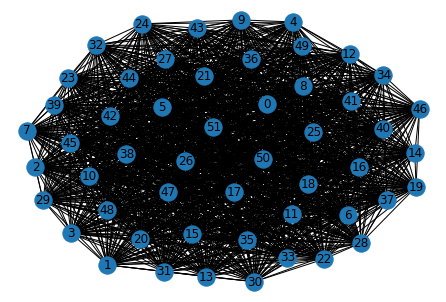

In [ ]:
nx.draw(G, with_labels = True)
plt.show()

## Community Detection

In [ ]:
#Leiden Community Detection
coms = algorithms.louvain(G)

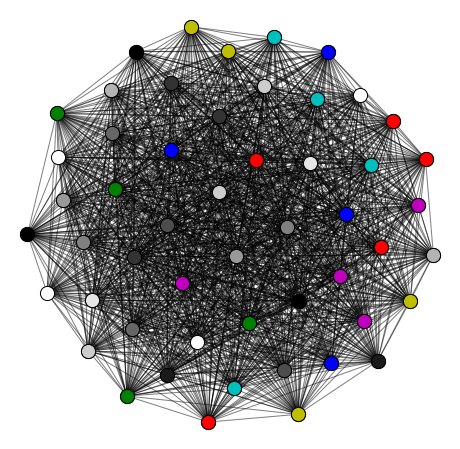

In [ ]:
pos = nx.spring_layout(G)
viz.plot_network_clusters(G, coms, pos)

In [ ]:
coms.communities

[[13, 20, 23, 24, 30],
 [3, 15, 16, 17],
 [4, 21, 28, 41],
 [9, 10, 11, 14],
 [12, 31, 42, 51],
 [36, 37, 38, 39],
 [0, 1, 49],
 [32, 33, 34],
 [44, 45, 46],
 [5, 6],
 [7, 8],
 [18, 40],
 [19, 22],
 [26, 43],
 [35, 50],
 [47, 48],
 [2],
 [25],
 [27],
 [29]]

## Hierarchical Clustering

In [ ]:
import scipy
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import ward, dendrogram

In [ ]:
transform_simil= 1 - simil

In [ ]:
transform_simil=transform_simil.tolist()

In [ ]:
distVec = ssd.squareform(transform_simil)
linkage = hierarchy.linkage(1 - distVec, method='ward')

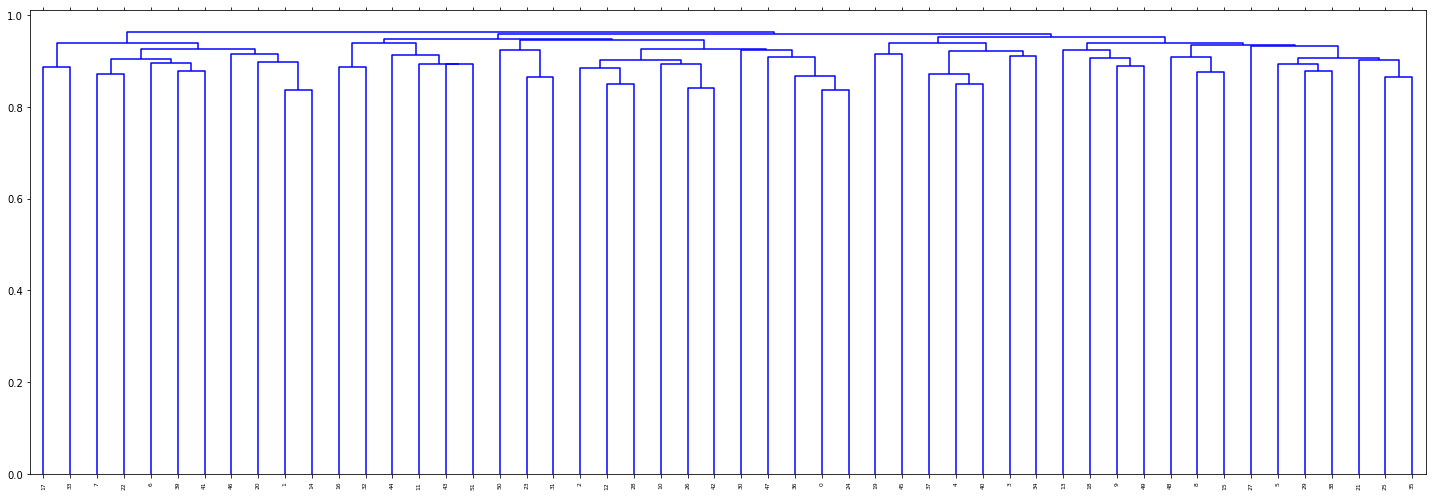

In [ ]:
 #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(20, 7)) # set size
ax = dendrogram(linkage);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) 

In [ ]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='ward')  #took n=5 from dendrogram curve 
Agg=cluster.fit_predict(simil)

In [ ]:
cluster.labels_

array([7, 7, 0, 4, 0, 0, 0, 2, 2, 2, 2, 2, 3, 4, 4, 5, 5, 5, 4, 0, 0, 4,
       0, 4, 4, 0, 0, 4, 0, 0, 4, 3, 1, 1, 1, 3, 6, 6, 6, 6, 0, 4, 3, 0,
       1, 1, 1, 1, 1, 3, 4, 0])

In [ ]:
# Giving Labels/assigning a cluster to each point/text 
temp['AVG-W2V Clus Label'] = cluster.labels_
temp

,Unnamed: 0,SourceID,Title,TextWhereRefMention,cleaned_text,AVG-W2V Clus Label
0,20974,2156,UK Transport Policy Paper delivered to the Eco...,"[It has been said often, but apparently not of...",It has been said often but apparently not ofte...,7
1,20975,2156,A New Deal for Transport?,"[It has been said often, but apparently not of...",It has been said often but apparently not ofte...,7
2,20976,2156,"The Eddington Transport Study, The case for ac...",In the UK context this has been illustrated re...,In the UK context this has been illustrated re...,0
3,20977,2156,A New Deal for Transport?,The current UK government has made many steps ...,The current UK government has made many steps ...,4
4,20978,2156,Evaluation of the implementation process of ur...,"Associated with traffic congestion, are the re...",Associated with traffic congestion are the rel...,0
5,20979,2156,"Unsustainable Transport, Transport, Developmen...","Some academics have reported, thoroughly the u...",Some academics have reported thoroughly the un...,0
6,20980,2156,Transport for a Sustainable Future â€“ The Cas...,"Some academics have reported, thoroughly the u...",Some academics have reported thoroughly the un...,0
7,20981,2156,Integrated Transport Strategies,The topic of merging policy measures into poli...,The topic of merging policy measures into poli...,2
8,20982,2156,Implementation paths for marginal-cost-based p...,The topic of merging policy measures into poli...,The topic of merging policy measures into poli...,2
9,20983,2156,"Department for Transport, Feasibility Study of...","Conclusions from many studies (, Ref{target=nu...",Conclusions from many studies have supported t...,2


## Summary Selection

In [ ]:
x=coms.communities

In [ ]:
liden_model_summary=[]
size=20
inc=0
for i in range(len(x)):
  for j in range(len(x[i])):
    if(inc <= size):  
      if temp['cleaned_text'][x[i][j]] not in liden_model_summary: 
        liden_model_summary.append(temp['cleaned_text'][x[i][j]])
        inc=inc+1

  

In [ ]:
liden_model_summary= '. '.join(liden_model_summary)

In [ ]:
liden_model_summary

'A recent action by the UK government was the creation of the Transport Innovation Fund to support experiments with a package of policies including road pricing. Support for these local schemes could come from the Transport Innovation Fund TIF which was outlined in the TIF report. In Scotland the Integrated Transport Bill TSO included proposals for congestion charging. The Scottish Transport Act was approved in 2001 TSO. The 2004 transport White Paper announced the intention of creating a Transport Innovation Fund as support to local authorities interested in using demand management to reduce traffic congestion. The current UK government has made many steps in rejecting the myth of the great car economy but the performance of their policies has been ambiguous. But the problem is that the UK government backed out too easily from its original promises as many academics agree and that it has fallen well short of the integrated transport aspirations expressed in the 1998 White Paper even b

## Hierarchical Clustering

In [ ]:
from collections import Counter
x = Counter(cluster.labels_.tolist())

In [ ]:
x = sorted(x.items(), key=lambda x: x[1], reverse=True)

In [ ]:
cluster_model_summ=[]
inc=0
for i, j in x:
  for k in range(len(temp)):
    if(i == temp['AVG-W2V Clus Label'][k]):
       if(inc <= size):  
        if temp['cleaned_text'][k] not in cluster_model_summ: 
          cluster_model_summ.append(temp['cleaned_text'][k])
          inc=inc+1
      


In [ ]:
cluster_model_summ= '. '.join(cluster_model_summ)

In [ ]:
cluster_model_summ

'In the UK context this has been illustrated recently in the Eddington report. Associated with traffic congestion are the related problems of air pollution emissions of CO 2 and other greenhouse gases together with more subtle lifestyle effects such as contributing to less healthy lifestyles and transport poverty. Some academics have reported thoroughly the unsustainability of current transport practices. The Road Pricing Feasibility Study explained the reason for the time scale of the national road pricing scheme as being the need to develop the appropriate technology which was not expected to be available until at least 2014. Support for these local schemes could come from the Transport Innovation Fund TIF which was outlined in the TIF report. For a number of reasons most notably the lack of political support and not least because of the proposed congestion technology the Cambridge scheme failed to progress beyond the field trial. Seven years later in 1998 it advanced to a pseudoarea

## Evaluation of Model

### Extracting the Abstract

In [ ]:
import urllib.request
import urllib.parse
import json
import pprint

In [ ]:
def get_title(id):
  url="https://core.ac.uk:443/api-v2/articles/get/"+str(id)+"?metadata=true&fulltext=false&citations=false&similar=false&duplicate=false&urls=false&faithfulMetadata=false&apiKey=TlQSpxe0br7cqOC8DhuZysm5zYV1kfwR"
  temp = urllib.request.urlopen(url).read()
  result = json.loads(temp.decode('utf-8'))
  if(result['status']=='OK'):
    return result['data']['title'], result['data']['description']
  else:
    print("Oops")

In [ ]:
id=temp['SourceID'][0]

In [ ]:
title, abst = get_title(id)

In [ ]:
abst

"This paper focuses on urban road pricing as a demand management policy that is often regarded as radical and generally unacceptable. Road pricing often gets delayed or abandoned due to low acceptability. This may be due to the fact that complex interactions and drivers of change affect road transport management and require cooperation within implementation networks. The implementation network is a group of people (referred to as partners and actors) who co-ordinate the introduction of policy tools. The drivers of change include any internal or external influences that have an effect on the time, place, or ‘shape’ of the policy measures being introduced. Demand management measures that focus on 'sustainable transport' usually address a limited set of objectives and are often implemented alone i.e. are not necessarily combined with other policy measures. When combined with other measures, it is not always clear whether the multiple interactions between policy tools and implementation ne

### Evaluation

In [ ]:
pip install rouge

In [ ]:
from rouge import Rouge

In [ ]:
rouge = Rouge()

In [ ]:
rouge.get_scores(liden_model_summary, abst)


[{'rouge-1': {'f': 0.31294117223338414,
   'p': 0.22504230118443316,
   'r': 0.5135135135135135},
  'rouge-2': {'f': 0.06132075048337961,
   'p': 0.04406779661016949,
   'r': 0.10077519379844961},
  'rouge-l': {'f': 0.204166662323698,
   'p': 0.14984709480122324,
   'r': 0.3202614379084967}}]

In [ ]:
rouge.get_scores(cluster_model_summ, abst)


[{'rouge-1': {'f': 0.2823218952373975,
   'p': 0.21442885771543085,
   'r': 0.41312741312741313},
  'rouge-2': {'f': 0.04497354047745069,
   'p': 0.03413654618473896,
   'r': 0.06589147286821706},
  'rouge-l': {'f': 0.17488788786935203,
   'p': 0.13310580204778158,
   'r': 0.2549019607843137}}]